# Ensemble models by:

- Daniela Martínez Quiroga
- María Isabella Rodríguez Arévalo

# Example 1: Cancer prediction

## Install libraries

In [ ]:
!pip install -U gradio
!pip install lightgbm xgboost

In [ ]:
import pandas as pd
import sklearn
import gradio as gr

from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
import lightgbm as lgb
import xgboost as xgb

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import LabelEncoder
import numpy as np


## Dataset and cleaning data

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/BoredDany/ML-Python/refs/heads/main/datasets/cancer.csv')
print(df.head())

x = df.drop('Diagnosis',axis=1)
x.fillna(x.mean(), inplace=True)
y = df['Diagnosis']

## Training/test data

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,stratify=y)

## Train model

In [ ]:
# Models for Voting clasifier
mod3_op1 = LogisticRegression(penalty='elasticnet', solver='saga',max_iter=1000, l1_ratio=0.5)
mod3_op2 = SVC(kernel='linear')
mod3_op3 = SVC(kernel='poly', degree=2, gamma='scale')
mod3_op4 = SVC(kernel='rbf', gamma='scale')
mod3_op5 = DecisionTreeClassifier(criterion='entropy', max_depth=15, max_leaf_nodes=10, min_impurity_decrease=0.0000001, min_samples_leaf=2)

mod3_op1.fit(x_train, y_train)
mod3_op2.fit(x_train, y_train)
mod3_op3.fit(x_train, y_train)
mod3_op4.fit(x_train, y_train)
mod3_op5.fit(x_train, y_train)

# Models for Stacking classifier
mod4_op1 =DecisionTreeClassifier(criterion='gini', max_depth=10, max_leaf_nodes=10, min_impurity_decrease=0.0000001, min_samples_leaf=2)
mod4_op2 = SVC(kernel='linear')
mod4_op3 = SVC(kernel='poly', degree=2, gamma='auto')
mod4_op4 = SVC(kernel='rbf', gamma='auto')

mod4_op1.fit(x_train, y_train)
mod4_op2.fit(x_train, y_train)
mod4_op3.fit(x_train, y_train)
mod4_op4.fit(x_train, y_train)

# Ensemble models
ens_op1 = RandomForestClassifier(n_estimators=100, criterion='entropy')
ens_op2 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1)
ens_op3 = VotingClassifier([('lr', mod3_op1), ('svc_lin', mod3_op2), ('svc_poly', mod3_op3), ('svc_rbf', mod3_op4), ('dt', mod3_op5)], voting='hard')
ens_op4 = StackingClassifier(estimators=[('dt', mod4_op1), ('svc_lin', mod4_op2), ('svc_poly', mod4_op3), ('svc_rbf', mod4_op4)], final_estimator=LogisticRegression())

ens_op1.fit(x_train, y_train)
ens_op2.fit(x_train, y_train)
ens_op3.fit(x_train, y_train)
ens_op4.fit(x_train, y_train)

## Comparative table

The table indicates that the model with the best Accuracy and F1 Score on training data is Gradient Boosting Classifier. On the other hand, the model with the best results on the metrics on test data is Stacking Classifier.

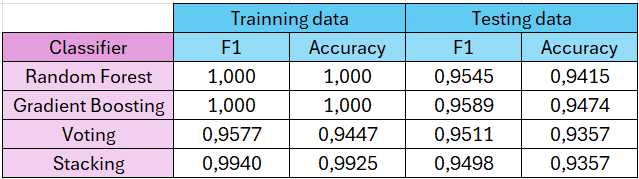

In [ ]:
models = [ens_op1, ens_op2, ens_op3, ens_op4]
model_names = ["RandomForestClassifier", "GradientBoostingClassifier", "VotingClassifier", "StackingClassifier"]

for model, model_name in zip(models, model_names):
    # Predictions for training and test data
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)

    # Calculate accuracy for training and test data
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)

    # Calculate F1 score for training and test data
    f1_train = f1_score(y_train, y_pred_train, pos_label='B')
    f1_test = f1_score(y_test, y_pred_test, pos_label='B')

    # Print the results
    print(f"{model_name}:")
    print(f"  Training Accuracy = {acc_train:.4f}, Training F1 Score = {f1_train:.4f}")
    print(f"  Test Accuracy = {acc_test:.4f}, Test F1 Score = {f1_test:.4f}")
    print("-" * 30)  # Separator for better readability

# Example 2 - Real Estate

## Load and clean data

In [ ]:
url = "https://raw.githubusercontent.com/BoredDany/ML-Python/refs/heads/main/datasets/houses.csv"
df = pd.read_csv(url)

# Separate features and target variable
x = df.drop('SalePrice', axis=1)
y = df['SalePrice']

# Identify categorical and numerical columns
categorical_cols = x.select_dtypes(include=['object']).columns
numerical_cols = x.select_dtypes(include=['number']).columns

# Fill missing values
x[numerical_cols] = x[numerical_cols].fillna(x[numerical_cols].mean())  # For numerical
x[categorical_cols] = x[categorical_cols].fillna(x[categorical_cols].mode().iloc[0])  # For categorical

# Convert categorical variables to numerical variables (One-Hot Encoding)
x = pd.get_dummies(x, columns=categorical_cols, drop_first=True)  # Avoids collinearity

# Verify that there are no categorical values after the transformation
print("Data types after get_dummies:\n", x.dtypes.value_counts())

# Split into training (70%) and testing (30%)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

print(f'Size of x_train: {x_train.shape}')
print(f'Size of x_test: {x_test.shape}')
print(f'Size of y_train: {y_train.shape}')
print(f'Size of y_test: {y_test.shape}')

## Ensemble

In [ ]:
# Define models
models = {
    "RandomForest": RandomForestRegressor(random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "LightGBM": lgb.LGBMRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(random_state=42)
}

# Evaluate models
results = {}
for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)

    results[name] = {
        "MSE_train": mean_squared_error(y_train, y_pred_train),
        "MSE_test": mean_squared_error(y_test, y_pred_test),
        "MAE_train": mean_absolute_error(y_train, y_pred_train),
        "MAE_test": mean_absolute_error(y_test, y_pred_test),
        "R2_train": r2_score(y_train, y_pred_train),
        "R2_test": r2_score(y_test, y_pred_test)
    }

# Define the ensemble model with StackingClassifier
estimators = [(name, model) for name, model in models.items()]
stacking_model = StackingClassifier(estimators=estimators, final_estimator=GradientBoostingClassifier(random_state=42))
stacking_model.fit(x_train, y_train)

# Evaluate the ensemble model
y_pred_train_stack = stacking_model.predict(x_train)
y_pred_test_stack = stacking_model.predict(x_test)

results["Stacking"] = {
    "MSE_train": mean_squared_error(y_train, y_pred_train_stack),
    "MSE_test": mean_squared_error(y_test, y_pred_test_stack),
    "MAE_train": mean_absolute_error(y_train, y_pred_train_stack),
    "MAE_test": mean_absolute_error(y_test, y_pred_test_stack),
    "R2_train": r2_score(y_train, y_pred_train_stack),
    "R2_test": r2_score(y_test, y_pred_test_stack)
}

In [ ]:
# Show results
for model_name, metrics in results.items():
    print(f"{model_name}:")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value:.4f}")
    print()

## Gradio interface

In [ ]:
import gradio as gr

# Read and parse the data description file
def parse_file(filepath):
    fields = {}
    with open(filepath, "r", encoding="utf-8") as file:
        lines = file.readlines()

    current_field = None
    for line in lines:
        line = line.strip()
        if not line:
            continue

        if ":" in line:
            field_name = line.split(":")[0].strip()
            fields[field_name] = []
            current_field = field_name
        elif current_field and "\t" in line:
            option = line.split("\t")[0].strip()
            fields[current_field].append(option)

    return fields

def predict_price(**kwargs):
    rf_model = models["RandomForest"]
    input_data = pd.DataFrame([kwargs])
    prediction = rf_model.predict(input_data)[0]
    return "Datos ingresados:\n" + "\n".join([f"{key}: {value}" for key, value in kwargs.items()]) + f"\n\nPrediction: {prediction}"

# Read the data from the file
data_file = "/content/data_description.txt"
fields = parse_file(data_file)

# Create the components dynamically
inputs = []
for field, options in fields.items():
    if options:
        inputs.append(gr.Dropdown(choices=options, label=field))
    else:
        inputs.append(gr.Textbox(label=field))

iface = gr.Interface(fn=predict_price, inputs=inputs, outputs="text")
iface.launch()